# Creating a dataset and dataloader script mode.

We are using the jupyter cell magic command to create script `%%writefile filename`

In [ ]:
import torch
import torchvision

In [ ]:
torch.__version__

'2.0.0+cu118'

In [ ]:
torchvision.__version__

'0.15.1+cu118'

We will import the codes we wrote in previous section to this section so we dont rewrite them

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3710, done.
remote: Counting objects: 100% (332/332), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 3710 (delta 176), reused 301 (delta 155), pack-reused 3378
Receiving objects: 100% (3710/3710), 648.79 MiB | 33.68 MiB/s, done.
Resolving deltas: 100% (2132/2132), done.
Updating files: 100% (248/248), done.


In [ ]:
# setup device agnostic code
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# get data ready

In [ ]:
import os
import zipfile
from pathlib import Path
import requests

data_path= Path('data/')
image_path= data_path/'pizza_steak_sushi'

# if the image data doesnt exist, download the data from github
if image_path.is_dir():
  print (f'{image_path} already exist')
else:
  image_path.mkdir(parents= True, exist_ok= True)
  with open(data_path/'pizza_steak_sushi.zip', 'wb') as f:
    request= requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    f.write(request.content)

  # unzip the file
  with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
    zip_ref.extractall(image_path)

# remove .zip file
os.remove(data_path/ 'pizza_steak_sushi.zip')


In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
# setup the directory path
train_dir= image_path/ 'train'
test_dir= image_path / 'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
tst = '/content/data/pizza_steak_sushi/test/pizza/1152100.jpg'

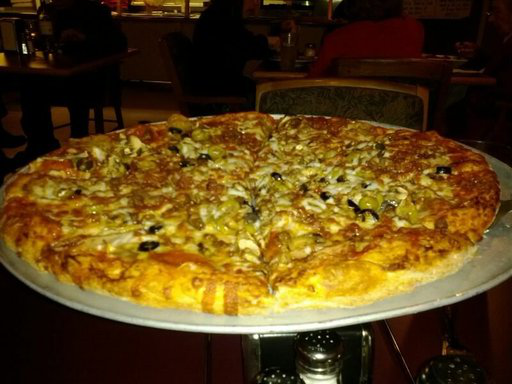

In [ ]:
from PIL import Image
Image.open('/content/data/pizza_steak_sushi/test/pizza/1152100.jpg')

## Creating dataloaders for transfer learning:

### Creating a manually created transforms for `torchvision.models` (manual creation). This was for old version

>All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:
>
>

In [ ]:
from going_modular.going_modular import data_setup

In [ ]:
# the mean and std are gotten from the torchvision website v12
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transforms= transforms.Compose([
    transforms.Resize(size= (224, 224)),
    transforms.ToTensor(),
    normalize # make sure the image have the same distribution as the imagenet (where our model has been trained on)
])

In [ ]:
train_dataloader, test_dataloader, class_names= data_setup.create_dataloaders(train_dir= train_dir,
                                                                              test_dir= test_dir,
                                                                              batch_size= 32,
                                                                              transform= manual_transforms,num_workers=2)

In [ ]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fad31acdf00>,
 ['pizza', 'steak', 'sushi'])

# creating a data transforms automatically (autocreation)

In [ ]:
# get a set of pretrained model weights
weight= torchvision.models.EfficientNet_B0_Weights.DEFAULT # 'default is the best available/performing weights
dir(weight)

['__class__',
 '__doc__',
 '__module__',
 'get_state_dict',
 'meta',
 'name',
 'transforms',
 'url',
 'value',
 'verify']

In [ ]:
# get the transforms used to create our pretrained weights
auto_transforms= weight.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# create dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names= data_setup.create_dataloaders(train_dir= train_dir,
                                                                              test_dir= test_dir,
                                                                              batch_size= 32,
                                                                              transform= auto_transforms,
                                                                              num_workers=2)

In [ ]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fad31acf6a0>,
 ['pizza', 'steak', 'sushi'])

# setting up a pretrained model

* creating an instance of efficientnet v0

In [ ]:
# creating an instance of efficientnet v0
weights= torchvision.models.EfficientNet_B0_Weights.DEFAULT
model= torchvision.models.efficientnet_b0(weights= weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 27.9MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
model.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

* we have to change the out_features to 3 because we our data has three classes

## Getting a summary of our model with torchinfo

In [ ]:
# values_copy
# print a summary with torch info
from torchinfo import summary

summary(model= model,
        input_size= (1,3,224,224), # example of size of data we want to pass into our model
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings= ['var_names'])

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

## Freezing the base model and changing the output layer to suit our model

In [ ]:
# freeze all base layers in the efficientnetb0 model. (baselayer is model.features)
for params in model.features.parameters():
  params.requires_grad= False
  #print (params)

In [ ]:
summary(model= model,
        input_size= (1,3,224,224), # example of size of data we want to pass into our model
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings= ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# update classifier head to suit our model

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier= nn.Sequential(
    nn.Dropout(p=0.2, inplace= True),
    nn.Linear(in_features=1280, out_features=3, bias= True).to(device)
)

In [ ]:
summary(model= model,
        input_size= (1,3,224,224), # example of size of data we want to pass into our model
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings= ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Train model with transfer learning

In [ ]:
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# import train function
from going_modular.going_modular import engine

# set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start timer
from timeit import default_timer as timer
start_time = timer()
# train_data
result= engine.train(model= model,
                     train_dataloader= train_dataloader,
                     test_dataloader= test_dataloader,
                     optimizer= optimizer,
                     loss_fn= loss_fn,
                     epochs=5,
                     device=device)
end_time= timer()
print (f'time taken is {end_time- start_time}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
time taken is 22.073251777999985


# plot a loss curve

In [ ]:
result

{'train_loss': [1.092943362891674,
  0.8702964261174202,
  0.7647757083177567,
  0.7114483937621117,
  0.6252278387546539],
 'train_acc': [0.40234375, 0.77734375, 0.80078125, 0.7578125, 0.79296875],
 'test_loss': [0.9124558766682943,
  0.7900150219599406,
  0.7433413664499918,
  0.6344443957010905,
  0.6237563093503317],
 'test_acc': [0.5501893939393939,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8863636363636364]}

In [ ]:
result['train_loss']

[1.092943362891674,
 0.8702964261174202,
 0.7647757083177567,
 0.7114483937621117,
 0.6252278387546539]

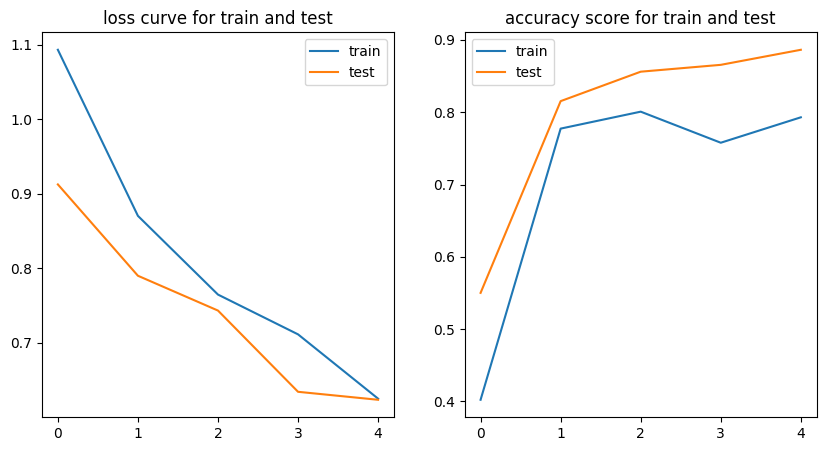

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(result['train_loss'], label= 'train')
plt.plot(result['test_loss'], label= 'test')
plt.title('loss curve for train and test')
plt.legend();
plt.subplot(1,2,2)
plt.plot(result['train_acc'], label= 'train')
plt.plot(result['test_acc'], label= 'test')
plt.title('accuracy score for train and test')
plt.legend();

# Making predictions on the test data

In [ ]:
from typing import List, Tuple
from torchvision import transforms
def pred_and_plot_image(model,
                        class_names: list[str],
                        image_path: str,
                        image_size: Tuple[int, int] = (224,224),
                        transform = None,
                        device= device):
  fig = Image.open(image_path)

  if transform is not None:
    img_transform = transforms

  else:
    img_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
                             ])
  model.to(device)
  model.eval()
  with torch.inference_mode():
    # transform the image and add an extra dimension
    transformed_image= img_transform(fig).unsqueeze(dim=0) #batch size, color channel, height, width
    # make a pred on the transformed image
    pred= model(transformed_image.to(device))
    # convert model output logits to pred probs
    pred_probs= torch.softmax(pred, dim=1)
    # convert pred prob to pred lable
    pred_label= torch.argmax(pred_probs, dim=1)

  # plot the image with predicted label and prob
  plt.figure()
  plt.imshow(fig)
  plt.title(f"pred: {class_names[pred_label]} | prob: {pred_probs.max():.3f}")
  plt.axis(False)



In [ ]:
# testing our code
import random
test_image= list(Path(test_dir).glob('*/*.jpg'))
sample= random.sample(population= test_image, k=3)
sample

[PosixPath('data/pizza_steak_sushi/test/pizza/648055.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg')]

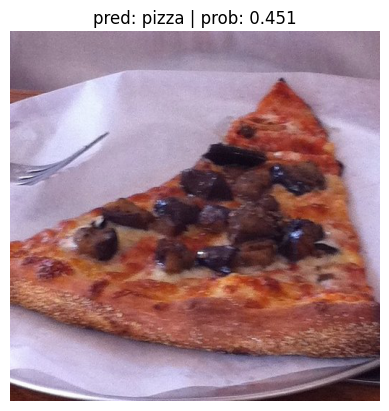

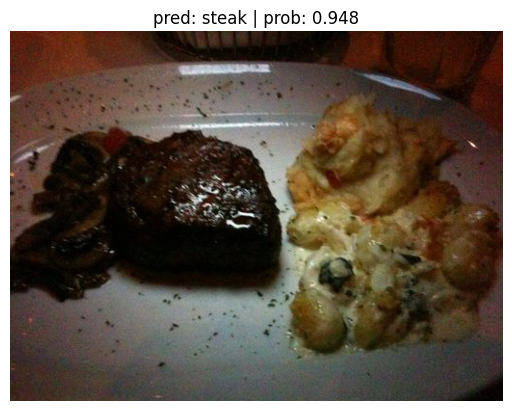

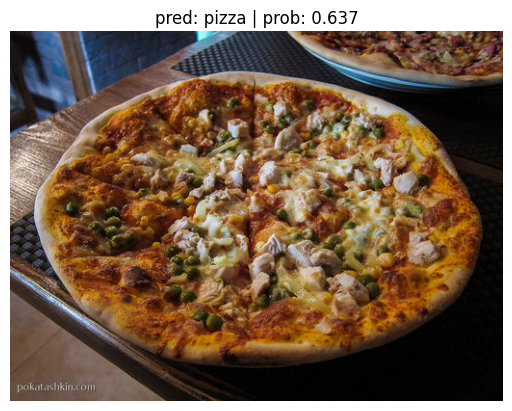

In [ ]:
# make predictions and plot the images
for i in sample:
  pred_and_plot_image(
      model= model,
      image_path=i,
      class_names= class_names,
      image_size=(224,224),
  )

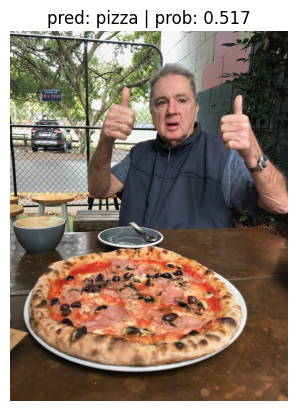

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)